#**Imports**

In [1]:
import  copy
import  datetime
import  json
import  matplotlib.dates as mdates
import  matplotlib.pyplot as plt
import  numpy as np
import  os
import  pandas as pd
import  pickle
from    pprint import pprint
import  random
from    sklearn.metrics import mean_squared_error
import  time
import  torch
import  torch.nn as nn
import  torch.nn.functional as F
from    torch.optim import lr_scheduler
from    torch.utils.data import Dataset, DataLoader
from    tqdm.notebook import tqdm
from    typing import Literal
import  yaml

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Device: {device}")

Device: cuda


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
plt.rcParams["font.family"] = "monospace"

In [4]:
DATA_DIR = '/content/drive/MyDrive/NLX/ind-assignment/data'
FIG_DIR = '/content/drive/MyDrive/NLX/ind-assignment/figs'
EXP_DIR = '/content/drive/MyDrive/NLX/ind-assignment/experiments'

#**Config**

In [5]:
config = {
    'max_epoch': 100,
    'use_sentiment': True,
    'init_lr': 1e-3,
    'weight_decay': 0.10,
    'lstm_layers': 3,
    'lstm_hidden_size': 1024,
    'lstm_dropout': 0.2
}

In [6]:
SENTIMENT = 'Using Sentiment' if config['use_sentiment'] else 'Not Using Sentiment'
print(SENTIMENT)

Using Sentiment


#**Dataset**

In [7]:
with open(os.path.join(DATA_DIR, 'data.pkl'), 'rb') as f:
    data = pickle.load(f)

data.keys()

dict_keys(['all_instances', 'pre_test_instances', 'post_test_instances', 'test_instances'])

In [8]:
len(data['test_instances'])

113

In [9]:
# data['pre_test_instances'][0]

##**Class**

In [22]:
class GmeDataset(Dataset):

    def __init__(self,
                 instances,
                 features = Literal[
                     'sentiment_long',
                     'sentiment_short',
                     'no_sentiment',
                     'synthetic_pos',
                     'synthetic_bin',
                 ]):

        self.instances = instances
        self.length = len(instances)

        feature_candidates = [
            'sentiment_long',
            'sentiment_short',
            'no_sentiment',
            'synthetic_pos',
            'synthetic_bin',
        ]
        if features in feature_candidates:
            self.features   = features
        else:
            raise ValueError(f"features must be one of {feature_candidates}")

    def __len__(self):

        return self.length

    def __getitem__(self, idx):

        (target,
         feat_sentiment_long, feat_sentiment_short,
         feat_no_sentiment,
         feat_synth_pos, feat_synth_bin) = self.instances[idx]

        target = torch.tensor(target, dtype=torch.float32)
        if self.features == 'sentiment_long':
            feat = torch.from_numpy(feat_sentiment_long)
        elif self.features == 'sentiment_short':
            feat = torch.from_numpy(feat_sentiment_short)
        elif self.features == 'no_sentiment':
            feat = torch.from_numpy(feat_no_sentiment)
        elif self.features == 'synthetic_pos':
            feat = torch.from_numpy(feat_synth_pos)
        elif self.features == 'synthetic_bin':
            feat = torch.from_numpy(feat_synth_bin)
        feat = feat.to(torch.float32)

        return target, feat

##**Instantiate**

###**Sentiment (Long)**

In [13]:
# Sentiment (Long)
full_data_sent_long    = GmeDataset(data['all_instances'], features='sentiment_long')
train_data_sent_long   = GmeDataset(data['pre_test_instances'], features='sentiment_long')
val_data_sent_long     = GmeDataset(data['post_test_instances'], features='sentiment_long')
test_data_sent_long    = GmeDataset(data['test_instances'], features='sentiment_long')

full_loader_sent_long = DataLoader(
    full_data_sent_long,
    batch_size=len(data['all_instances']),
    shuffle=False, pin_memory=True, num_workers = 2
)
train_loader_sent_long = DataLoader(
    train_data_sent_long,
    batch_size=len(data['pre_test_instances']),
    shuffle=True, pin_memory=True, num_workers = 2
)
val_loader_sent_long = DataLoader(
    val_data_sent_long,
    batch_size=len(data['post_test_instances']),
    shuffle=False, pin_memory=True, num_workers = 2
)
test_loader_sent_long = DataLoader(
    test_data_sent_long,
    batch_size=len(data['test_instances']),
    shuffle=False, pin_memory=True, num_workers = 2
)

###**Sentiment (Short)**

In [14]:
# Sentiment (Short)
full_data_sent_short   = GmeDataset(data['all_instances'], features='sentiment_short')
train_data_sent_short  = GmeDataset(data['pre_test_instances'], features='sentiment_short')
val_data_sent_short    = GmeDataset(data['post_test_instances'], features='sentiment_short')
test_data_sent_short   = GmeDataset(data['test_instances'], features='sentiment_short')

full_loader_sent_short = DataLoader(
    full_data_sent_short,
    batch_size=len(data['all_instances']),
    shuffle=False, pin_memory=True, num_workers = 2
)
train_loader_sent_short = DataLoader(
    train_data_sent_short,
    batch_size=len(data['pre_test_instances']),
    shuffle=True, pin_memory=True, num_workers = 2
)
val_loader_sent_short = DataLoader(
    val_data_sent_short,
    batch_size=len(data['post_test_instances']),
    shuffle=False, pin_memory=True, num_workers = 2
)
test_loader_sent_short = DataLoader(
    test_data_sent_short,
    batch_size=len(data['test_instances']),
    shuffle=False, pin_memory=True, num_workers = 2
)

###**No Sentiment**

In [15]:
# No sentiment
full_data_nosent       = GmeDataset(data['all_instances'], features='no_sentiment')
train_data_nosent      = GmeDataset(data['pre_test_instances'], features='no_sentiment')
val_data_nosent        = GmeDataset(data['post_test_instances'], features='no_sentiment')
test_data_nosent       = GmeDataset(data['test_instances'], features='no_sentiment')

full_loader_nosent = DataLoader(
    full_data_nosent,
    batch_size=len(data['all_instances']),
    shuffle=False, pin_memory=True, num_workers = 2
)
train_loader_nosent = DataLoader(
    train_data_nosent,
    batch_size=len(data['pre_test_instances']),
    shuffle=True, pin_memory=True, num_workers = 2
)
val_loader_nosent = DataLoader(
    val_data_nosent,
    batch_size=len(data['post_test_instances']),
    shuffle=False, pin_memory=True, num_workers = 2
)
test_loader_nosent = DataLoader(
    test_data_nosent,
    batch_size=len(data['test_instances']),
    shuffle=False, pin_memory=True, num_workers = 2
)

##**Synthetic (positive)**

In [23]:
# No sentiment
full_data_synth_pos       = GmeDataset(data['all_instances'], features='synthetic_pos')
train_data_synth_pos      = GmeDataset(data['pre_test_instances'], features='synthetic_pos')
val_data_synth_pos        = GmeDataset(data['post_test_instances'], features='synthetic_pos')
test_data_synth_pos       = GmeDataset(data['test_instances'], features='synthetic_pos')

full_loader_synth_pos = DataLoader(
    full_data_synth_pos,
    batch_size=len(data['all_instances']),
    shuffle=False, pin_memory=True, num_workers = 2
)
train_loader_synth_pos = DataLoader(
    train_data_synth_pos,
    batch_size=len(data['pre_test_instances']),
    shuffle=True, pin_memory=True, num_workers = 2
)
val_loader_synth_pos = DataLoader(
    val_data_synth_pos,
    batch_size=len(data['post_test_instances']),
    shuffle=False, pin_memory=True, num_workers = 2
)
test_loader_synth_pos = DataLoader(
    test_data_synth_pos,
    batch_size=len(data['test_instances']),
    shuffle=False, pin_memory=True, num_workers = 2
)

##**Synthetic (Binomial)**

In [24]:
# No sentiment
full_data_synth_bin       = GmeDataset(data['all_instances'], features='synthetic_bin')
train_data_synth_bin      = GmeDataset(data['pre_test_instances'], features='synthetic_bin')
val_data_synth_bin        = GmeDataset(data['post_test_instances'], features='synthetic_bin')
test_data_synth_bin       = GmeDataset(data['test_instances'], features='synthetic_bin')

full_loader_synth_bin = DataLoader(
    full_data_synth_bin,
    batch_size=len(data['all_instances']),
    shuffle=False, pin_memory=True, num_workers = 2
)
train_loader_synth_bin = DataLoader(
    train_data_synth_bin,
    batch_size=len(data['pre_test_instances']),
    shuffle=True, pin_memory=True, num_workers = 2
)
val_loader_synth_bin = DataLoader(
    val_data_synth_bin,
    batch_size=len(data['post_test_instances']),
    shuffle=False, pin_memory=True, num_workers = 2
)
test_loader_synth_bin = DataLoader(
    test_data_synth_bin,
    batch_size=len(data['test_instances']),
    shuffle=False, pin_memory=True, num_workers = 2
)

###**Try Loaders**

In [25]:
for target, feat in full_loader_sent_long:
    print(target.shape, feat.shape, feat.dtype)
    break
for target, feat in test_loader_sent_long:
    print(target.shape, feat.shape, feat.dtype)
    break
for target, feat in train_loader_sent_long:
    print(target.shape, feat.shape, feat.dtype)
    break
for target, feat in val_loader_sent_long:
    print(target.shape, feat.shape, feat.dtype)
    break
##############################################################
for target, feat in full_loader_sent_short:
    print(target.shape, feat.shape, feat.dtype)
    break
for target, feat in test_loader_sent_short:
    print(target.shape, feat.shape, feat.dtype)
    break
for target, feat in train_loader_sent_short:
    print(target.shape, feat.shape, feat.dtype)
    break
for target, feat in val_loader_sent_short:
    print(target.shape, feat.shape, feat.dtype)
    break
##############################################################
for target, feat in full_loader_nosent:
    print(target.shape, feat.shape, feat.dtype)
    break
for target, feat in test_loader_nosent:
    print(target.shape, feat.shape, feat.dtype)
    break
for target, feat in train_loader_nosent:
    print(target.shape, feat.shape, feat.dtype)
    break
for target, feat in val_loader_nosent:
    print(target.shape, feat.shape, feat.dtype)
    break
##############################################################
for target, feat in full_loader_synth_pos:
    print(target.shape, feat.shape, feat.dtype)
    break
for target, feat in test_loader_synth_pos:
    print(target.shape, feat.shape, feat.dtype)
    break
for target, feat in train_loader_synth_pos:
    print(target.shape, feat.shape, feat.dtype)
    break
for target, feat in val_loader_synth_pos:
    print(target.shape, feat.shape, feat.dtype)
    break
##############################################################
for target, feat in full_loader_synth_bin:
    print(target.shape, feat.shape, feat.dtype)
    break
for target, feat in test_loader_synth_bin:
    print(target.shape, feat.shape, feat.dtype)
    break
for target, feat in train_loader_synth_bin:
    print(target.shape, feat.shape, feat.dtype)
    break
for target, feat in val_loader_synth_bin:
    print(target.shape, feat.shape, feat.dtype)
    break

torch.Size([342, 21, 1]) torch.Size([342, 21, 19]) torch.float32
torch.Size([113, 21, 1]) torch.Size([113, 21, 19]) torch.float32
torch.Size([127, 21, 1]) torch.Size([127, 21, 19]) torch.float32
torch.Size([102, 21, 1]) torch.Size([102, 21, 19]) torch.float32
torch.Size([342, 21, 1]) torch.Size([342, 21, 10]) torch.float32
torch.Size([113, 21, 1]) torch.Size([113, 21, 10]) torch.float32
torch.Size([127, 21, 1]) torch.Size([127, 21, 10]) torch.float32
torch.Size([102, 21, 1]) torch.Size([102, 21, 10]) torch.float32
torch.Size([342, 21, 1]) torch.Size([342, 21, 7]) torch.float32
torch.Size([113, 21, 1]) torch.Size([113, 21, 7]) torch.float32
torch.Size([127, 21, 1]) torch.Size([127, 21, 7]) torch.float32
torch.Size([102, 21, 1]) torch.Size([102, 21, 7]) torch.float32
torch.Size([342, 21, 1]) torch.Size([342, 21, 10]) torch.float32
torch.Size([113, 21, 1]) torch.Size([113, 21, 10]) torch.float32
torch.Size([127, 21, 1]) torch.Size([127, 21, 10]) torch.float32
torch.Size([102, 21, 1]) torc

In [ ]:
def visualize_example(ex_target, ex_feat):
    # ex_target = float(ex_target.cpu())
    ex_feat = ex_feat.cpu().numpy()

    fig, ax = plt.subplots(1)
    ax.set_title(f'{ex_target}')
    ax.plot(ex_feat)

# visualize_example(target[0], feat[0])

#**Model Class**

https://machinelearningmastery.com/lstm-for-time-series-prediction-in-pytorch/

In [26]:
INSIZE_SENT_LONG    = train_data_sent_long[0][-1].shape[-1]
INSIZE_SENT_SHORT   = train_data_sent_short[0][-1].shape[-1]
INSIZE_NOSENT       = train_data_nosent[0][-1].shape[-1]

print(f"INSIZE_SENT_LONG:  {INSIZE_SENT_LONG}")
print(f"INSIZE_SENT_SHORT: {INSIZE_SENT_SHORT}")
print(f"INSIZE_NOSENT:     {INSIZE_NOSENT}")


INSIZE_SENT_LONG:  19
INSIZE_SENT_SHORT: 10
INSIZE_NOSENT:     7


In [27]:
class LstmModel(nn.Module):

    def __init__(self, in_size):

        super(LstmModel, self).__init__()

        self.lstm = nn.LSTM(
            input_size=in_size,
            hidden_size=config['lstm_hidden_size'],
            num_layers=config['lstm_layers'],
            batch_first=True,
            dropout=config['lstm_dropout']
        )
        self.fc = nn.Linear(config['lstm_hidden_size'], 1)

    def forward(self, x, debug=False):
        out, (hn, cn) = self.lstm(x)
        if debug: print(out.shape, hn.shape, cn.shape)
        out = self.fc(out)
        if debug: print(out.shape)
        return out

In [28]:
example_model = LstmModel(INSIZE_SENT_SHORT)
example_model(feat, debug=True);

torch.Size([102, 21, 1024]) torch.Size([3, 102, 1024]) torch.Size([3, 102, 1024])
torch.Size([102, 21, 1])


#**Trainer**

In [29]:
def train_epoch(model, optimizer, criterion, scheduler, scaler, tloader):

    model.train()
    total_loss = 0.0

    for i, (target, feat) in enumerate(tloader):

        # Reset gradients
        optimizer.zero_grad()

        # Move data to device
        target, feat = target.to(device), feat.to(device)

        # Make predictions
        pred = model(feat)

        # Calculate loss and add to total loss
        loss = torch.sqrt(criterion(target, pred))
        total_loss += float(loss.item())

        # Backprog and optimizer step
        loss.backward()
        optimizer.step()

        del target, feat, pred, loss
        torch.cuda.empty_cache()

    total_loss = float(total_loss / len(tloader))

    return total_loss

In [30]:
def eval_epoch(model, criterion, vloader):

    model.eval()
    total_loss = 0.0

    for i, (target, feat) in enumerate(vloader):

        # Move data to device
        target, feat = target.to(device), feat.to(device)

        # In inference mode, make predictions and calc loss
        with torch.inference_mode():
            pred = model(feat)
            loss = torch.sqrt(criterion(target, pred))
        total_loss += float(loss.item())

        del target, feat, pred, loss
        torch.cuda.empty_cache()

    total_loss = float(total_loss / len(vloader))

    return total_loss

In [31]:
def save_checkpoint(fpath, model, optimizer, scheduler, epoch, metric):
    torch.save(
        {
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'epoch': epoch,
            metric[0]: metric[1]
        },
        fpath
    )
    print(f'Saved checkpoint: {fpath}')

In [32]:
def train(model, optimizer, criterion, scheduler, scaler, tloader, vloader,
          end_epoch, start_epoch=0):

    best_ckpt_name = f'ckpt_{str(int(time.time()))}'
    best_ckpt_path = os.path.join(EXP_DIR, f'{best_ckpt_name}.pth')

    curr_best = float('inf')
    tlosses = []
    vlosses = []
    for epoch in range(start_epoch, end_epoch):

        print(f"\n================= EPOCH {epoch} / {end_epoch} =================")

        if optimizer.param_groups[0]['lr'] < 1e-8:
            break

        tloss = train_epoch(model, optimizer, criterion, scheduler, scaler, tloader)
        vloss = eval_epoch(model, criterion, vloader)

        print(f"tloss = {tloss:.2f}, vloss = {vloss:.2f}, lr = {optimizer.param_groups[0]['lr']:.5f}")

        # Step scheduler
        scheduler.step(vloss)

        # If loss is better than current, save checkpoint and update
        if vloss < curr_best:
            curr_best = vloss
            save_checkpoint(
                best_ckpt_path, model, optimizer, scheduler, epoch, ['vloss', vloss]
            )

        tlosses.append(tloss)
        vlosses.append(vloss)

    print(f"Training finished! Use this checkpoint: {best_ckpt_path}")

    return tlosses, vlosses, best_ckpt_name, best_ckpt_path


#**Training**

##**Define Model, Optim, Scheduler**

In [33]:
criterion = nn.MSELoss()

In [34]:
model_sent_long     = LstmModel(INSIZE_SENT_LONG).to(device)
model_sent_short    = LstmModel(INSIZE_SENT_SHORT).to(device)
model_nosent        = LstmModel(INSIZE_NOSENT).to(device)
model_synth         = LstmModel(INSIZE_SENT_SHORT).to(device)

In [35]:
optimizer_sent_long = torch.optim.AdamW(
    model_sent_long.parameters(),
    lr=config['init_lr'],
    weight_decay=config['weight_decay']
)
optimizer_sent_short = torch.optim.AdamW(
    model_sent_short.parameters(),
    lr=config['init_lr'],
    weight_decay=config['weight_decay']
)
optimizer_nosent = torch.optim.AdamW(
    model_nosent.parameters(),
    lr=config['init_lr'],
    weight_decay=config['weight_decay']
)

In [36]:
scheduler_sent_long = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer_sent_long,
    mode='min',
    factor=0.1,
    patience=10
)
scheduler_sent_short = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer_sent_short,
    mode='min',
    factor=0.1,
    patience=10
)
scheduler_nosent = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer_nosent,
    mode='min',
    factor=0.1,
    patience=10
)

In [37]:
scaler_sent_long = torch.cuda.amp.GradScaler()
scaler_sent_short = torch.cuda.amp.GradScaler()
scaler_nosent = torch.cuda.amp.GradScaler()

##**Train**

In [ ]:
(tlosses_sent_long, vlosses_sent_long,
 ckpt_name_sent_long, ckpt_path_sent_long) = train(
    model       = model_sent_long,
    optimizer   = optimizer_sent_long,
    criterion   = criterion,
    scheduler   = scheduler_sent_long,
    scaler      = scaler_sent_long,
    tloader     = train_loader_sent_long,
    vloader     = val_loader_sent_long,
    end_epoch   = config['max_epoch'],
    start_epoch = 0
)


================= EPOCH 0 / 50 =================
tloss = 0.94, vloss = 0.62, lr = 0.00100
Saved checkpoint: /content/drive/MyDrive/NLX/ind-assignment/experiments/ckpt_1707626811.pth

================= EPOCH 1 / 50 =================
tloss = 0.87, vloss = 0.56, lr = 0.00100
Saved checkpoint: /content/drive/MyDrive/NLX/ind-assignment/experiments/ckpt_1707626811.pth

================= EPOCH 2 / 50 =================
tloss = 0.80, vloss = 0.48, lr = 0.00100
Saved checkpoint: /content/drive/MyDrive/NLX/ind-assignment/experiments/ckpt_1707626811.pth

================= EPOCH 3 / 50 =================
tloss = 0.76, vloss = 0.48, lr = 0.00100
Saved checkpoint: /content/drive/MyDrive/NLX/ind-assignment/experiments/ckpt_1707626811.pth

================= EPOCH 4 / 50 =================
tloss = 0.70, vloss = 0.48, lr = 0.00100

================= EPOCH 5 / 50 =================
tloss = 0.64, vloss = 0.48, lr = 0.00100
Saved checkpoint: /content/drive/MyDrive/NLX/ind-assignment/experiments/ckpt_170762681

In [ ]:
(tlosses_sent_short, vlosses_sent_short,
 ckpt_name_sent_short, ckpt_path_sent_short) = train(
    model       = model_sent_short,
    optimizer   = optimizer_sent_short,
    criterion   = criterion,
    scheduler   = scheduler_sent_short,
    scaler      = scaler_sent_short,
    tloader     = train_loader_sent_short,
    vloader     = val_loader_sent_short,
    end_epoch   = config['max_epoch'],
    start_epoch = 0
)


================= EPOCH 0 / 50 =================
tloss = 0.94, vloss = 0.60, lr = 0.00100
Saved checkpoint: /content/drive/MyDrive/NLX/ind-assignment/experiments/ckpt_1707626826.pth

================= EPOCH 1 / 50 =================
tloss = 0.89, vloss = 0.49, lr = 0.00100
Saved checkpoint: /content/drive/MyDrive/NLX/ind-assignment/experiments/ckpt_1707626826.pth

================= EPOCH 2 / 50 =================
tloss = 0.82, vloss = 0.34, lr = 0.00100
Saved checkpoint: /content/drive/MyDrive/NLX/ind-assignment/experiments/ckpt_1707626826.pth

================= EPOCH 3 / 50 =================
tloss = 0.77, vloss = 0.32, lr = 0.00100
Saved checkpoint: /content/drive/MyDrive/NLX/ind-assignment/experiments/ckpt_1707626826.pth

================= EPOCH 4 / 50 =================
tloss = 0.73, vloss = 0.37, lr = 0.00100

================= EPOCH 5 / 50 =================
tloss = 0.66, vloss = 0.41, lr = 0.00100

================= EPOCH 6 / 50 =================
tloss = 0.62, vloss = 0.41, lr = 0.0

In [ ]:
(tlosses_nosent, vlosses_nosent,
 ckpt_name_nosent, ckpt_path_nosent) = train(
    model       = model_nosent,
    optimizer   = optimizer_nosent,
    criterion   = criterion,
    scheduler   = scheduler_nosent,
    scaler      = scaler_nosent,
    tloader     = train_loader_nosent,
    vloader     = val_loader_nosent,
    end_epoch   = config['max_epoch'],
    start_epoch = 0
)


================= EPOCH 0 / 50 =================
tloss = 0.94, vloss = 0.60, lr = 0.00100
Saved checkpoint: /content/drive/MyDrive/NLX/ind-assignment/experiments/ckpt_1707626841.pth

================= EPOCH 1 / 50 =================
tloss = 0.88, vloss = 0.47, lr = 0.00100
Saved checkpoint: /content/drive/MyDrive/NLX/ind-assignment/experiments/ckpt_1707626841.pth

================= EPOCH 2 / 50 =================
tloss = 0.81, vloss = 0.31, lr = 0.00100
Saved checkpoint: /content/drive/MyDrive/NLX/ind-assignment/experiments/ckpt_1707626841.pth

================= EPOCH 3 / 50 =================
tloss = 0.76, vloss = 0.29, lr = 0.00100
Saved checkpoint: /content/drive/MyDrive/NLX/ind-assignment/experiments/ckpt_1707626841.pth

================= EPOCH 4 / 50 =================
tloss = 0.71, vloss = 0.33, lr = 0.00100

================= EPOCH 5 / 50 =================
tloss = 0.64, vloss = 0.38, lr = 0.00100

================= EPOCH 6 / 50 =================
tloss = 0.60, vloss = 0.37, lr = 0.0

#**Save Results**

#**Visualize Predictions**

In [ ]:
################################################################################
# Load checkpoints and model for sentiment (long)
best_ckpt_sent = torch.load(ckpt_path_sent_long)
prediction_model_sent = copy.deepcopy(model_sent_long)
prediction_model_sent.load_state_dict(best_ckpt_sent['model_state_dict'])

for test_targets, feat in full_loader_sent_long:
    with torch.inference_mode():
        feat = feat.to(device)
        test_targets = test_targets.to(device)[:, -1, :]
        test_pred_sent_long = prediction_model_sent(feat, debug=True)[:, -1, :]

################################################################################
# Load checkpoints and model for sentiment (short)
best_ckpt_sent = torch.load(ckpt_path_sent_short)
prediction_model_sent = copy.deepcopy(model_sent_short)
prediction_model_sent.load_state_dict(best_ckpt_sent['model_state_dict'])

for test_targets, feat in full_loader_sent_short:
    with torch.inference_mode():
        feat = feat.to(device)
        test_targets = test_targets.to(device)[:, -1, :]
        test_pred_sent_short = prediction_model_sent(feat, debug=True)[:, -1, :]

################################################################################
# Load checkpoints and model for no sentiment
best_ckpt_nosent = torch.load(ckpt_path_nosent)
prediction_model_nosent = copy.deepcopy(model_nosent)
prediction_model_nosent.load_state_dict(best_ckpt_nosent['model_state_dict'])

for test_targets, feat in full_loader_nosent:
    with torch.inference_mode():
        feat = feat.to(device)
        test_targets = test_targets.to(device)[:, -1, :]
        test_pred_nosent = prediction_model_nosent(feat, debug=True)[:, -1, :]

################################################################################
# Convert to numpy
test_targets_np         = test_targets.cpu().numpy()
test_pred_sent_long_np  = test_pred_sent_long.cpu().numpy()
test_pred_sent_short_np = test_pred_sent_short.cpu().numpy()
test_pred_nosent_np     = test_pred_nosent.cpu().numpy()

torch.Size([342, 21, 512]) torch.Size([2, 342, 512]) torch.Size([2, 342, 512])
torch.Size([342, 21, 1])


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:879: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


torch.Size([342, 21, 512]) torch.Size([2, 342, 512]) torch.Size([2, 342, 512])
torch.Size([342, 21, 1])
torch.Size([342, 21, 512]) torch.Size([2, 342, 512]) torch.Size([2, 342, 512])
torch.Size([342, 21, 1])


In [ ]:
results = {
    'sentiment_long': {
        'ckpt': ckpt_name_sent_long,
        'tloss': tlosses_sent_long,
        'vloss': vlosses_sent_long,
        'target': test_targets_np,
        'predictions': test_pred_sent_long_np
    },
    'sentiment_short': {
        'ckpt': ckpt_name_sent_short,
        'tloss': tlosses_sent_short,
        'vloss': vlosses_sent_short,
        'target': test_targets_np,
        'predictions': test_pred_sent_short_np
    },
    'nosentiment': {
        'ckpt': ckpt_name_nosent,
        'tloss': tlosses_nosent,
        'vloss': vlosses_nosent,
        'target': test_targets_np,
        'predictions': test_pred_nosent_np
    },
}

with open(os.path.join(EXP_DIR, f'{ckpt_name_sent_long}.pkl'), 'wb') as f:
    pickle.dump(results, f)

In [ ]:
def plot_losses(results, save=False):

    # Sentiment (Long)
    plt.plot(results['sentiment_long']['tloss'],
             color='red', label='tLoss (Sentiment (long))')
    plt.plot(results['sentiment_long']['vloss'],
             color='red', label='vLoss (Sentiment (long))', linewidth=3)

    # Sentiment (Short)
    plt.plot(results['sentiment_short']['tloss'],
             color='green', label='tLoss (Sentiment (short))')
    plt.plot(results['sentiment_short']['vloss'],
             color='green', label='vLoss (Sentiment (short))', linewidth=3)

    # No Sentiment
    plt.plot(results['nosentiment']['tloss'],
             color='blue', label='tLoss (No Sentiment)')
    plt.plot(results['nosentiment']['vloss'],
             color='blue', label='vLoss (No Sentiment)', linewidth=3)

    # Cosmetics
    plt.title(f'Model Training')
    plt.ylabel('Loss (RMSE, Standardized GME Close)')
    plt.xlabel('Epoch')
    plt.legend()
    if save:
        plt.savefig(os.path.join(FIG_DIR, f"{results['sentiment_long']['ckpt']}_training.png"))
        print('Saved!')
    plt.show()

Saved!


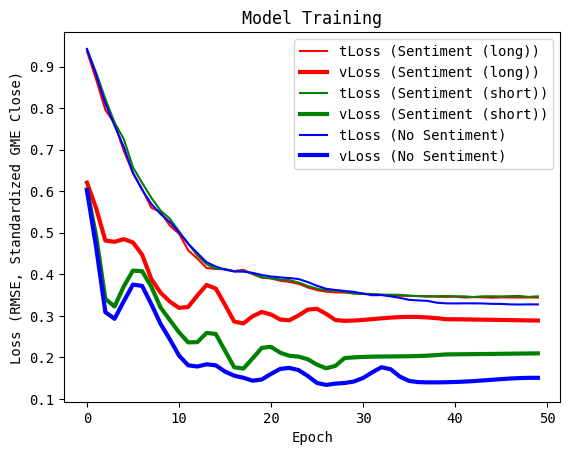

In [ ]:
plot_losses(results, save=True)

In [48]:
with open(os.path.join(DATA_DIR, 'date_x.pkl'), 'rb') as f:
    X_DATES = pickle.load(f)[21:]
print(X_DATES)
with open(os.path.join(DATA_DIR, 'standardization.pkl'), 'rb') as f:
    CLOSE_PARAMS = pickle.load(f)
print(CLOSE_PARAMS)

21     2021-01-25 00:00:00-05:00
22     2021-01-26 00:00:00-05:00
23     2021-01-27 00:00:00-05:00
24     2021-01-28 00:00:00-05:00
25     2021-01-29 00:00:00-05:00
                 ...            
358    2021-12-28 00:00:00-05:00
359    2021-12-29 00:00:00-05:00
360    2021-12-30 00:00:00-05:00
361    2021-12-31 00:00:00-05:00
362    2022-01-01 00:00:00-05:00
Name: date, Length: 342, dtype: object
(35.15305738513534, 18.68329453136681)


In [49]:
def unstd(x, parameters=CLOSE_PARAMS):
    """
    Unstandardize.
    Args
    ---------
    x: standardized array
    parameters: [mean, std]

    Formulas
    ---------
    standardized = (original - mean) / (std + 1e-6)
    original = standardized * (std + 1e-6) + mean
    """

    out = x * (parameters[1] + 1e-6) + parameters[0]

    return out

In [ ]:
unstd_tgt_sent_long     = unstd(results['sentiment_long']['target'])
unstd_pred_sent_long    = unstd(results['sentiment_long']['predictions'])
print(type(unstd_pred_sent_long))

unstd_tgt_sent_short    = unstd(results['sentiment_short']['target'])
unstd_pred_sent_short   = unstd(results['sentiment_short']['predictions'])

unstd_tgt_nosent        = unstd(results['nosentiment']['target'])
unstd_pred_nosent       = unstd(results['nosentiment']['predictions'])

rmse_sent_long      = np.sqrt(mean_squared_error(unstd_tgt_sent_long, unstd_pred_sent_long))
rmse_sent_short     = np.sqrt(mean_squared_error(unstd_tgt_sent_short, unstd_pred_sent_short))
rmse_nosent_long    = np.sqrt(mean_squared_error(unstd_tgt_nosent, unstd_pred_nosent))

print(f"Sentiment (Long) RMSE:  {rmse_sent_long:4f}")
print(f"Sentiment (Short) RMSE: {rmse_sent_short:4f}")
print(f"No Sentiment RMSE:      {rmse_nosent_long:4f}")

<class 'numpy.ndarray'>
Sentiment (Long) RMSE:  6.307976
Sentiment (Short) RMSE: 5.321635
No Sentiment RMSE:      4.685080


In [ ]:
def plot_predictions(results, save=False):

    fig, ax = plt.subplots(figsize=(10, 7))

    # Actuals
    plt.plot(X_DATES, unstd(results['sentiment_long']['target']),
             color='black', linewidth=2, label='Actual')

    # Predictions (Sentiment, Long)
    plt.plot(X_DATES, unstd(results['sentiment_long']['predictions']),
             color='red', linewidth=1.5, label=f'Prediction (Sentiment Long), RMSE: {rmse_sent_long:.2f}')

    # Predictions (Sentiment, Short)
    plt.plot(X_DATES, unstd(results['sentiment_short']['predictions']),
             color='green', linewidth=1.5, label=f'Prediction (Sentiment Short), RMSE: {rmse_sent_short:.2f}')

    # Predictions (No Sentiment)
    plt.plot(X_DATES, unstd(results['nosentiment']['predictions']),
             color='blue', linewidth=1.5, label=f'Prediction (No Sentiment), RMSE: {rmse_nosent_long:.2f}')

    # Vertical shading
    test_start = datetime.datetime(2021, 6, 1)
    test_end = datetime.datetime(2021, 9, 1)
    plt.axvspan(test_start, test_end, color='lightgray', alpha=0.5, label='Test Period')

    # Make dates look nice
    ax.xaxis.set_major_locator(mdates.MonthLocator())  # Locate by month
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))  # Format as Year-Month
    plt.gcf().autofmt_xdate()

    # Title and axes
    plt.title(f'Predictions vs. Actuals')
    plt.ylabel('GME Close Price (USD)')
    plt.xlabel('Date')

    plt.legend()
    plt.tight_layout()

    if save:
        plt.savefig(os.path.join(FIG_DIR, f"{results['sentiment_long']['ckpt']}_preds.png"))
        print('Saved!')

    plt.show()

Saved!


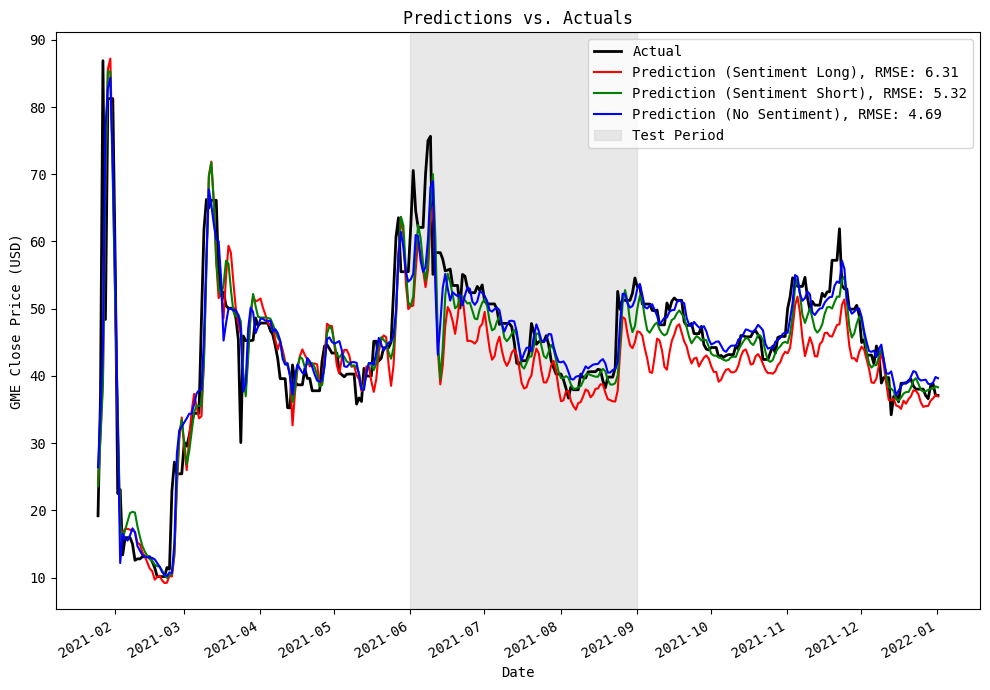

In [ ]:
plot_predictions(results, save=True)

#**Test on Synthetic Data**

In [40]:
# Best checkpoint
synth_ckpt_name = 'ckpt_1707625675.pth'
synth_ckpt_path = os.path.join(EXP_DIR, synth_ckpt_name)

synth_ckpt = torch.load(synth_ckpt_path)

model_synth.load_state_dict(synth_ckpt['model_state_dict'])

<All keys matched successfully>

In [51]:
for test_targets, feat in full_loader_synth_pos:
    with torch.inference_mode():
        feat = feat.to(device)
        test_targets = test_targets.to(device)[:, -1, :]
        test_pred_synth_pos = model_synth(feat, debug=True)[:, -1, :]

for test_targets, feat in full_loader_synth_bin:
    with torch.inference_mode():
        feat = feat.to(device)
        test_targets = test_targets.to(device)[:, -1, :]
        test_pred_synth_bin = model_synth(feat, debug=True)[:, -1, :]

for test_targets, feat in full_loader_sent_short:
    with torch.inference_mode():
        feat = feat.to(device)
        test_targets = test_targets.to(device)[:, -1, :]
        test_pred_sent_short = model_synth(feat, debug=True)[:, -1, :]

results_synth = {
    'synthetic_pos': {
        'target': test_targets.cpu().numpy(),
        'predictions': test_pred_synth_pos.cpu().numpy(),
    },
    'synthetic_bin': {
        'target': test_targets.cpu().numpy(),
        'predictions': test_pred_synth_bin.cpu().numpy(),
    },
    'sentiment_short': {
        'ckpt':
        'target': test_targets.cpu().numpy(),
        'predictions': test_pred_sent_short.cpu().numpy(),
    }
}

torch.Size([342, 21, 1024]) torch.Size([3, 342, 1024]) torch.Size([3, 342, 1024])
torch.Size([342, 21, 1])
torch.Size([342, 21, 1024]) torch.Size([3, 342, 1024]) torch.Size([3, 342, 1024])
torch.Size([342, 21, 1])
torch.Size([342, 21, 1024]) torch.Size([3, 342, 1024]) torch.Size([3, 342, 1024])
torch.Size([342, 21, 1])


In [58]:
def plot_synthetic_predictions(results, save=False):

    fig, ax = plt.subplots(figsize=(10, 7))

    # Actuals
    plt.plot(X_DATES, unstd(results['sentiment_short']['target']),
             color='black', linewidth=2, label='Sentiment Short')

    # Predictions (Sentiment, Long)
    plt.plot(X_DATES, unstd(results['synthetic_pos']['predictions']),
             color='red', linewidth=1.5, label=f'Synthethic Positive')

    # Predictions (Sentiment, Short)
    plt.plot(X_DATES, unstd(results['synthetic_bin']['predictions']),
             color='blue', linewidth=1.5, label=f'Synthetic Binomial')

    # Vertical shading
    test_start = datetime.datetime(2021, 6, 1)
    test_end = datetime.datetime(2021, 9, 1)
    plt.axvspan(test_start, test_end, color='lightgray', alpha=0.5, label='Test Period')

    # Make dates look nice
    ax.xaxis.set_major_locator(mdates.MonthLocator())  # Locate by month
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))  # Format as Year-Month
    plt.gcf().autofmt_xdate()

    # Title and axes
    plt.title(f'Predictions on Actual vs. Synthetic Data')
    plt.ylabel('GME Close Price (USD)')
    plt.xlabel('Date')

    plt.legend()
    plt.tight_layout()

    if save:
        plt.savefig(os.path.join(FIG_DIR, f"{synth_ckpt_name}.png"))
        print('Saved!')

    plt.show()

Saved!


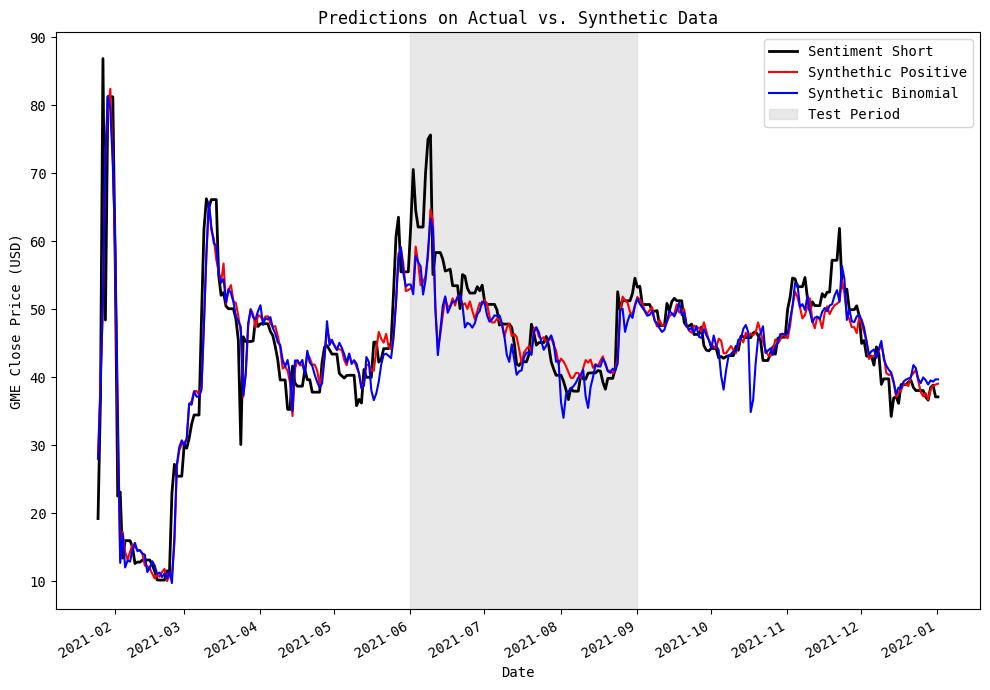

In [59]:
plot_synthetic_predictions(results_synth, save=True)